In [3]:
import gdspy
import qnldraw as qd
import qnldraw.library as qlib
from qnldraw import Chip, shapes, components
import qnldraw.paths as paths
import numpy as np
from qnldraw.junction import JunctionArray
from qnldraw.junction import JunctionLead

In [6]:
class JunctionArray(components.Component):
    __draw__ = True
    
    def draw(self, n, overlap, wire, undercut):
        jx, jy = overlap
        wx, wy = wire
        
        spacing = jy + wy
        
        positions = (np.arange(n) - (n-1)/2)*spacing
        
        for y in positions:
            junction_rect = shapes.Rectangle(jx, jy).translate(0, y)
            undercuts = [
                shapes.Rectangle(undercut, jy, 'right', layer=1).translate(-jx/2, y),
                shapes.Rectangle(undercut, jy, 'left', layer=1).translate(jx/2, y)
            ]
            
            self.add(junction_rect)
            self.add(undercuts)
            
        for i, y in enumerate(positions[:-1]):
            wire_rect = shapes.Rectangle(wx, wy, 'bottom').translate(0, y + 0.5*jy)
            undercuts = shapes.Rectangle(
                undercut, wy, 'bottom left' if i%2 else 'bottom right', layer=1
            ).translate(
                (2*(i%2) - 1)*wx/2, y + 0.5*jy
            )

            self.add(wire_rect)
            self.add(undercuts)
            
        nodes = {
            'wire1': np.array((0, positions[-1] + 0.5*jy)),
            'wire2': np.array((0, positions[0] - 0.5*jy))
        }
        return nodes

class AntennaSymmetric(components.Component):
    __draw__ = True
    
    def draw(self, pad, lead, gap):
        pad_x, pad_y = pad
        lead_x, lead_y = lead
        
        antenna = [
            shapes.Rectangle(pad_x, pad_y). translate((gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(pad_x, pad_y). translate(-(gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,0),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,0)
        ]
        self.add(antenna)
        nodes = {
            'left': (-gap/2,0),
            'right': (gap/2,0)
        }
        return nodes

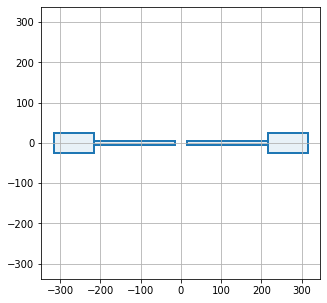

In [5]:
if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    chip = qd.Chip(size = (2000,1000))
    
    pad = (100,50)
    lead = (200, 10)
    gap = 30
    
    antenna = AntennaSymmetric(pad, lead, gap)
    
    params = {'number':100, 
          'overlap': [5, 0.2], 
          'wire':[0.4, 0.25], 
          'undercut': 0.8,
         'undercut_after_JJ': 1.2}

    n = params['number']
    overlap = params['overlap']
    wire = params['wire']
    undercut = params['undercut']
    undercut_after_JJ = params['undercut_after_JJ']
    array_gap = overlap[0] + 10
    offset = 5
    
    array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
    array1 = array.place((-array_gap/2, -offset), node='wire1', rotation=0)
    array2 = array.place((array_gap/2, -offset), node='wire1', rotation=0)

    lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset+n*(wire[1]+overlap[1])))
    fig = qd.plot(antenna)

    chip.add_component(antenna, cid = 'antenna', layers = 2)
    chip.add_component(array1, cid = 'array1', layers = 4)
    chip.add_component(array2, cid = 'array2', layers = 4)
    chip.add_component(lead, cid = 'lead', layers = 5)
    mask = chip.render(name = 'fluxonium', draw_border = True)
#     fig = qd.plot(mask[0], figsize=(20,20), axis=True, grid=False)